<a href="https://colab.research.google.com/github/xarvel/DataScience/blob/master/DCGAN_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [216]:
!pip install imageio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [217]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, LeakyReLU, Flatten, Reshape, BatchNormalization, Input, Conv2D, Dropout, Conv2DTranspose
from tensorflow.keras.models import Sequential
from tensorflow.keras import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.losses import BinaryCrossentropy
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm 
import time
import os
import tensorflow_datasets as tfds
import imageio
import glob
import IPython

In [218]:
#@title TPU CONFIG

resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
strategy = tf.distribute.TPUStrategy(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU')]


In [219]:
#@title CONFIG

IMAGE_SIZE = 28
IMAGE_CHANNELS = 1
LATENT_DIM = 100
EPOCHS = 20
BATCH_SIZE = 64
SAMPLE_INTERVAL = 1
DATASET_SIZE = 60000
SAMPLES_DIR = 'images'

In [220]:
def preprocess_image(img):
  img = tf.cast(img['image'], tf.float32) / 127.5 - 1.
  # img = tf.expand_dims(img, axis=3)
  return img

ds = tfds.load('mnist', split='train', shuffle_files=True, try_gcs=True)
dataset = ds.map(preprocess_image)
dataset = dataset.shuffle(DATASET_SIZE)
dataset = dataset.repeat()
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
dataset = dataset.prefetch(tf.data.AUTOTUNE)

per_replica_batch_size = BATCH_SIZE // strategy.num_replicas_in_sync

dataset = strategy.experimental_distribute_dataset(dataset)

In [221]:
class Generator(Model):
  def __init__(self):
    super(Generator, self).__init__()
   
    self.dense_1 = Dense(7 * 7 * 256, use_bias=False, input_shape=(LATENT_DIM,))
    self.bn_1 = BatchNormalization()
    self.lrelu_1 = LeakyReLU()
    self.reshape_1 = Reshape((7, 7, 256));

    self.conv2d_transpose_1 = Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False)
    self.bn_2 = BatchNormalization()
    self.lrelu_2 = LeakyReLU()

    self.conv2d_transpose_2 = Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False)

    self.bn_3 = BatchNormalization()
    self.lrelu_3 = LeakyReLU()

    self.conv2d_transpose_3 = Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')

  @tf.function
  def call(self, z, training=False):    
    x = self.dense_1(z)
    x = self.bn_1(x)
    x = self.lrelu_1(x)
    x = self.reshape_1(x)
    x = self.conv2d_transpose_1(x)
    x = self.bn_2(x)
    x = self.lrelu_2(x)
    x = self.conv2d_transpose_2(x)
    x = self.bn_3(x)
    x = self.lrelu_3(x)
    x = self.conv2d_transpose_3(x)

    return x

In [222]:
class Discriminator(Model):
  def __init__(self):
    super(Discriminator, self).__init__()
        
    self.conv2d_1 = Conv2D(64, (5, 5), 
                        strides=(2, 2), 
                        padding='same', 
                        input_shape=[IMAGE_SIZE, IMAGE_SIZE, IMAGE_CHANNELS]
                    )

    self.lrelu_1 = LeakyReLU()
    self.dropout_1 = Dropout(0.3)

    self.conv2d_2 = Conv2D(128, (5, 5), strides=(2, 2), padding='same')
    self.lrelu_2 = LeakyReLU()
    self.dropout_2 = Dropout(0.3)
    self.flatten = Flatten()
    self.dense = Dense(1)
  
  @tf.function
  def call(self, image, training=False):    
    x = self.conv2d_1(image)
    x = self.lrelu_1(x)
    x = self.dropout_1(x)
    x = self.conv2d_2(x)
    x = self.lrelu_2(x)
    x = self.dropout_2(x)
    x = self.flatten(x)
    x = self.dense(x)

    return x

In [223]:
with strategy.scope():
  generator = Generator()
  discriminator = Discriminator()

In [224]:
with strategy.scope():
  generator_optimizer = Adam(1e-4)
  discriminator_optimizer = Adam(1e-4)

In [225]:
with strategy.scope():
  cross_entropy = BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)

def discriminator_loss(logits_real: tf.Tensor, logits_fake: tf.Tensor) -> tf.Tensor :
  real_loss = cross_entropy(tf.ones_like(logits_real), logits_real)
  fake_loss = cross_entropy(tf.zeros_like(logits_fake), logits_fake)
  total_loss = real_loss + fake_loss

  return tf.nn.compute_average_loss(total_loss, global_batch_size=BATCH_SIZE)

def generator_loss(logits_fake: tf.Tensor) -> tf.Tensor:
  loss = cross_entropy(tf.ones_like(logits_fake), logits_fake)
  return tf.nn.compute_average_loss(loss, global_batch_size=BATCH_SIZE)

In [226]:
rows = 5
cols = 5

noise = np.random.normal(0, 1, (rows * cols, LATENT_DIM))

def sample_images(epoch=0, save=False, show=True):
  gen_imgs = generator(noise)
  gen_imgs = 0.5 * gen_imgs + 0.5

  fig, axs = plt.subplots(rows, cols)
  fig.subplots_adjust(
      wspace = 0.0,
      hspace = 0.0
  )
  px = 1/plt.rcParams['figure.dpi']

  fig.set_figheight(IMAGE_SIZE * rows * px)
  fig.set_figwidth(IMAGE_SIZE * cols * px)

  for i in range(rows):
    for j in range(cols):
      axs[i,j].imshow(gen_imgs[j * cols + i, :,:,0], cmap='gray')
  
      axs[i,j].axis('off')

  # Create folder if not exits
  if not os.path.isdir(SAMPLES_DIR):
    os.makedirs(SAMPLES_DIR, exist_ok=True)

  if save:
    plt.savefig(SAMPLES_DIR + '/image_at_epoch_{:04d}.png'.format(epoch))
    
  if show:
    plt.show()
  else:
    plt.close(fig)

In [227]:
steps_per_epoch = DATASET_SIZE // BATCH_SIZE

@tf.function
def train_step(iterator):

  def step_fn(images):
    noise = tf.random.normal([per_replica_batch_size, LATENT_DIM])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)
      gen_predictions = discriminator(generated_images, training=True)
      real_predictions = discriminator(images, training=True)
      
      disc_loss = discriminator_loss(real_predictions, gen_predictions)
      gen_loss = generator_loss(gen_predictions)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_weights)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_weights))
    
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_weights)
    discriminator_optimizer.apply_gradients(
        zip(gradients_of_discriminator, discriminator.trainable_weights)
    )

    return disc_loss, gen_loss


  disc_loss, gen_loss = strategy.run(step_fn, args=(next(iterator),))

  disc_loss = strategy.reduce(tf.distribute.ReduceOp.SUM, disc_loss, axis=None)
  gen_loss = strategy.reduce(tf.distribute.ReduceOp.SUM, gen_loss, axis=None) 

  return disc_loss, gen_loss

Number of devices: 8
Epoch: 1/20


Current step 937: 100%|██████████| 937/937 [00:38<00:00, 24.57it/s, disc_loss=1.05, gen_loss=0.879]


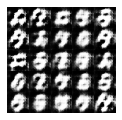

Time for epoch 1 is 39.182496070861816 sec
Epoch: 2/20


Current step 1874: 100%|██████████| 937/937 [00:21<00:00, 43.06it/s, disc_loss=1.26, gen_loss=0.93]


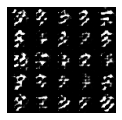

Time for epoch 2 is 22.923279762268066 sec
Epoch: 3/20


Current step 2811: 100%|██████████| 937/937 [00:22<00:00, 42.12it/s, disc_loss=1.23, gen_loss=0.856]


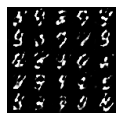

Time for epoch 3 is 23.067646265029907 sec
Epoch: 4/20


Current step 3748: 100%|██████████| 937/937 [00:27<00:00, 34.01it/s, disc_loss=1.14, gen_loss=1.08]


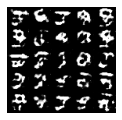

Time for epoch 4 is 28.78125286102295 sec
Epoch: 5/20


Current step 4685: 100%|██████████| 937/937 [00:23<00:00, 40.32it/s, disc_loss=1, gen_loss=1.47]


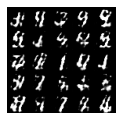

Time for epoch 5 is 24.446045398712158 sec
Epoch: 6/20


Current step 5622: 100%|██████████| 937/937 [00:21<00:00, 42.64it/s, disc_loss=1.08, gen_loss=1.11]


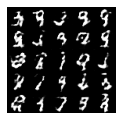

Time for epoch 6 is 22.820605516433716 sec
Epoch: 7/20


Current step 6559: 100%|██████████| 937/937 [00:22<00:00, 42.36it/s, disc_loss=0.803, gen_loss=1.3]


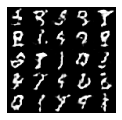

Time for epoch 7 is 22.937461853027344 sec
Epoch: 8/20


Current step 7496: 100%|██████████| 937/937 [00:22<00:00, 41.00it/s, disc_loss=1.18, gen_loss=1.22]


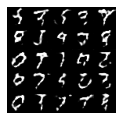

Time for epoch 8 is 24.083133697509766 sec
Epoch: 9/20


Current step 8433: 100%|██████████| 937/937 [00:22<00:00, 42.38it/s, disc_loss=1.45, gen_loss=1.04]


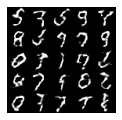

Time for epoch 9 is 22.950215101242065 sec
Epoch: 10/20


Current step 9370: 100%|██████████| 937/937 [00:22<00:00, 42.50it/s, disc_loss=1.3, gen_loss=1.05]


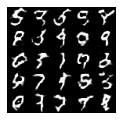

Time for epoch 10 is 22.92148995399475 sec
Epoch: 11/20


Current step 10307: 100%|██████████| 937/937 [00:22<00:00, 42.42it/s, disc_loss=1.2, gen_loss=1.02]


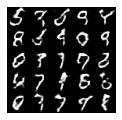

Time for epoch 11 is 23.32912564277649 sec
Epoch: 12/20


Current step 11244: 100%|██████████| 937/937 [00:22<00:00, 42.30it/s, disc_loss=1.22, gen_loss=1.1]


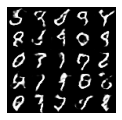

Time for epoch 12 is 22.968944787979126 sec
Epoch: 13/20


Current step 12181: 100%|██████████| 937/937 [00:21<00:00, 42.93it/s, disc_loss=1.37, gen_loss=0.778]


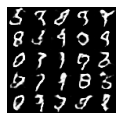

Time for epoch 13 is 22.64946484565735 sec
Epoch: 14/20


Current step 13118: 100%|██████████| 937/937 [00:22<00:00, 42.46it/s, disc_loss=1.24, gen_loss=0.935]


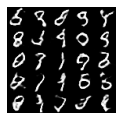

Time for epoch 14 is 23.23853874206543 sec
Epoch: 15/20


Current step 14055: 100%|██████████| 937/937 [00:22<00:00, 42.43it/s, disc_loss=1.11, gen_loss=1.04]


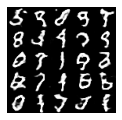

Time for epoch 15 is 22.923218250274658 sec
Epoch: 16/20


Current step 14992: 100%|██████████| 937/937 [00:21<00:00, 42.68it/s, disc_loss=1.28, gen_loss=0.871]


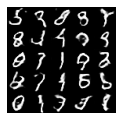

Time for epoch 16 is 22.784082174301147 sec
Epoch: 17/20


Current step 15929: 100%|██████████| 937/937 [00:21<00:00, 42.95it/s, disc_loss=1.28, gen_loss=1.14]


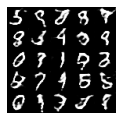

Time for epoch 17 is 22.99880027770996 sec
Epoch: 18/20


Current step 16866: 100%|██████████| 937/937 [00:21<00:00, 42.66it/s, disc_loss=1.34, gen_loss=0.922]


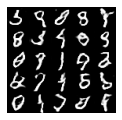

Time for epoch 18 is 22.786627292633057 sec
Epoch: 19/20


Current step 17803: 100%|██████████| 937/937 [00:21<00:00, 43.33it/s, disc_loss=1.22, gen_loss=0.967]


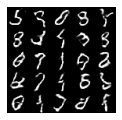

Time for epoch 19 is 22.445184469223022 sec
Epoch: 20/20


Current step 18740: 100%|██████████| 937/937 [00:21<00:00, 42.82it/s, disc_loss=1.11, gen_loss=0.958]


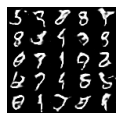

Time for epoch 20 is 23.098915815353394 sec


In [228]:
print ('Number of devices: {}'.format(strategy.num_replicas_in_sync))

train_iterator = iter(dataset)

for epoch in range(1, EPOCHS + 1):
  start = time.time()
  print('Epoch: {}/{}'.format(epoch, EPOCHS))

  pbar = tqdm(range(steps_per_epoch))
  for step in pbar:
    disc_loss, gen_loss = train_step(train_iterator)
 
    pbar.set_postfix({'disc_loss': round(float(disc_loss), 4), 'gen_loss': round(float(gen_loss), 4)})
    pbar.set_description("Current step %s" % generator_optimizer.iterations.numpy())
    
  if epoch % SAMPLE_INTERVAL == 0:
    sample_images(epoch, save=True, show=True);
  
  print('Time for epoch {} is {} sec'.format(epoch, time.time()-start))

In [229]:
anim_file = SAMPLES_DIR + '/all_images.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob(SAMPLES_DIR + '/image_at_epoch_*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)

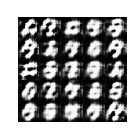

In [230]:
IPython.display.Image(filename=anim_file, embed=True)